In [1]:
import pickle
import os
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from visualisation_utils import VisualisationUtils

utils = VisualisationUtils()
sns.set_context("talk")
sns.set_style("white")

### Section 3.2: Control setup

In [2]:
def control_setup():
    metavalidation_results = defaultdict(lambda: dict())
    
    for modeln, model in utils.model_setups:
        for dataset_name in utils.control_setup_ds_names:
            accuracy1, accuracy2 = [], []
            for target, freeze in utils.control_setups: 
                filename = f"../results/layer_retraining/{dataset_name}/{model}_seed=1_freeze={freeze}_epoch=50.pt.pickle"
                heatmap, averages = utils.get_heatmap_and_averages(filename, retraining=True)
                layers = np.argsort(averages)[-2:]
                for l in layers:
                    accuracy2.append(l in target)
                accuracy1.append(layers[-1] in target)

            metavalidation_results[modeln, dataset_name]["accuracy@1"] = np.mean(accuracy1)
            metavalidation_results[modeln, dataset_name]["accuracy@2"] = np.mean(accuracy2)
    
    pickle.dump(dict(metavalidation_results), open("pickled_results/retraining_control.pickle", 'wb'))


control_setup()

### Section 4.1, Figures 3, 4, 5 (top row), (& Appendix A.1, Figure 13 top rows)

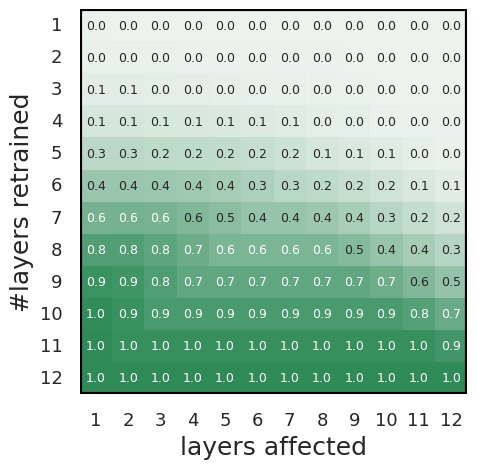

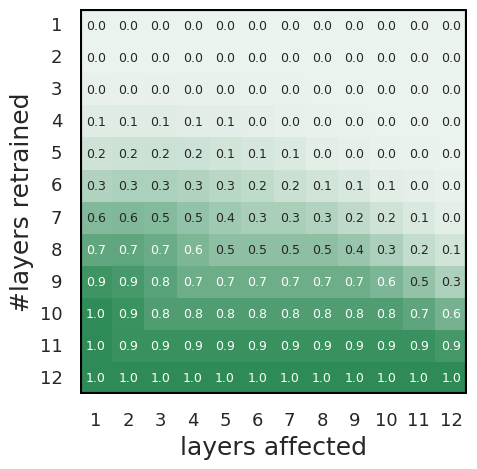

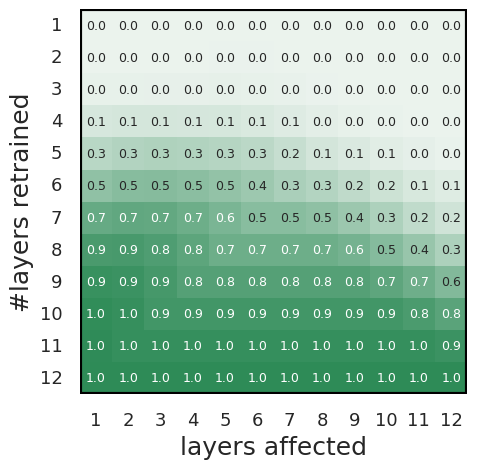

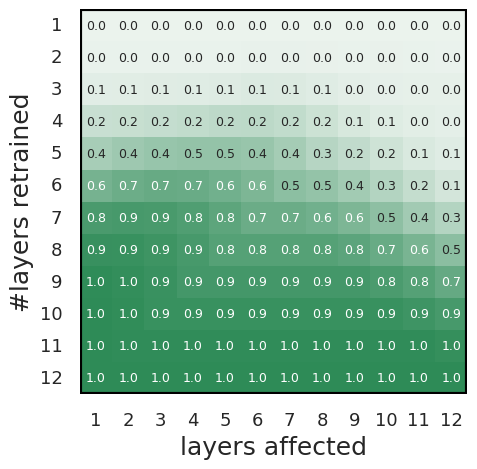

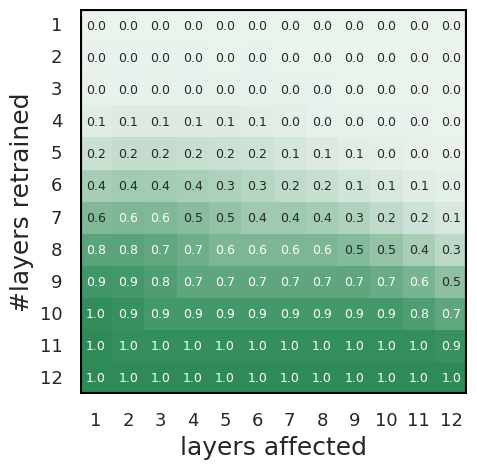

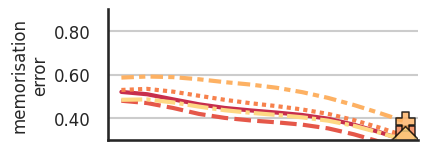

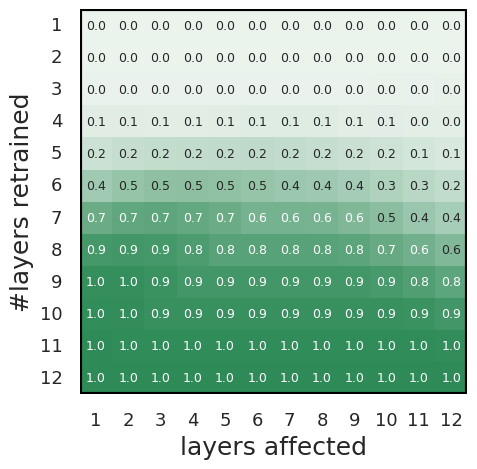

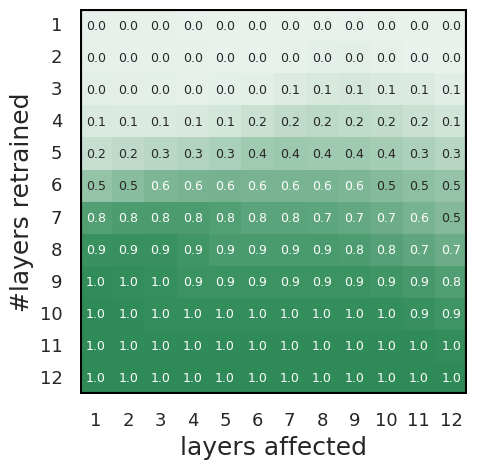

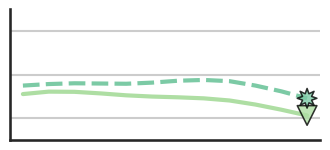

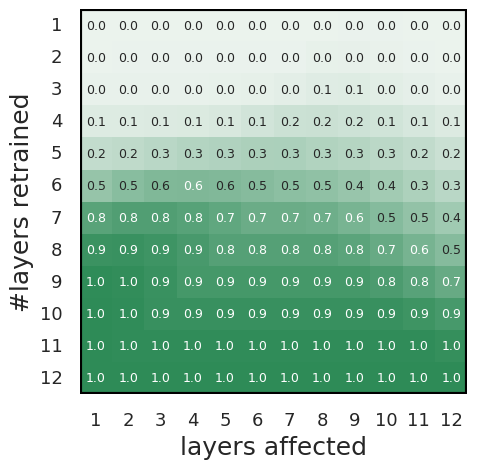

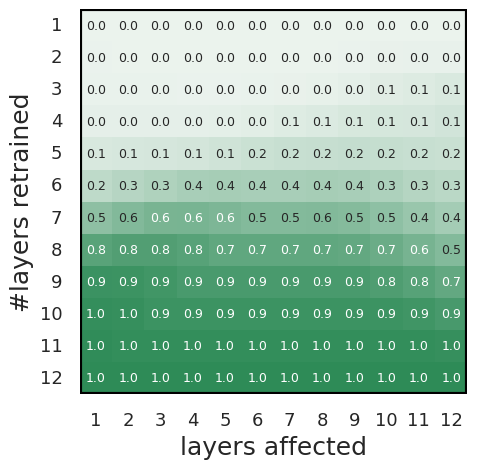

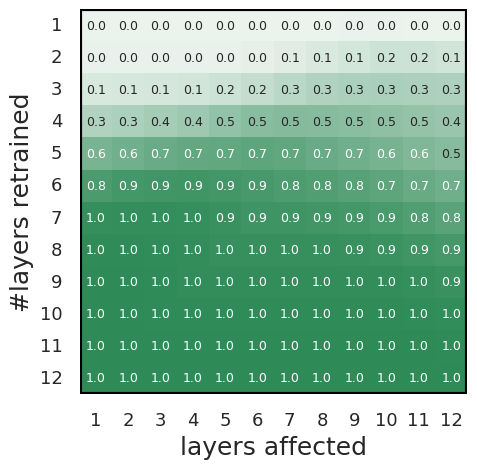

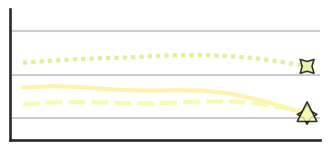

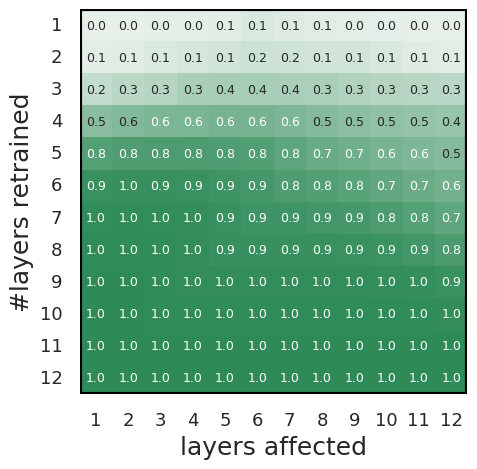

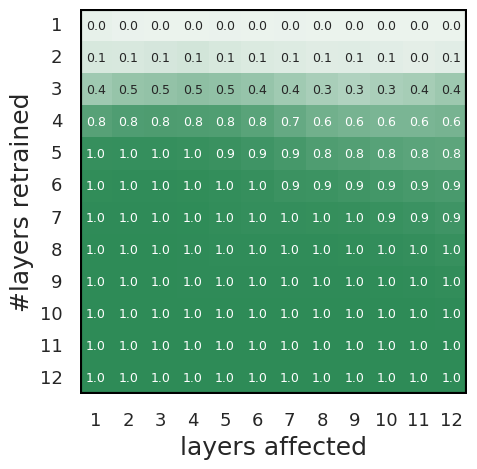

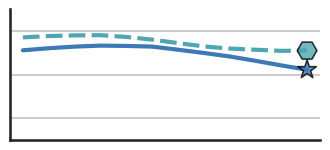

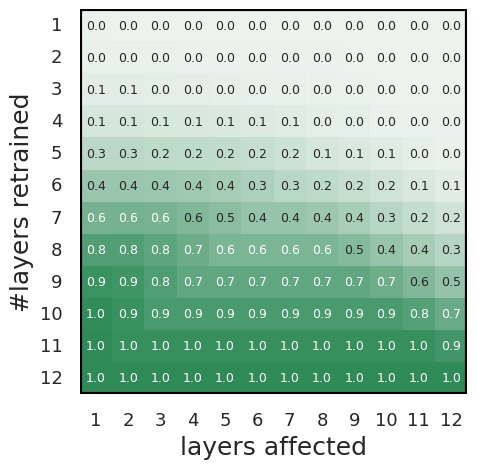

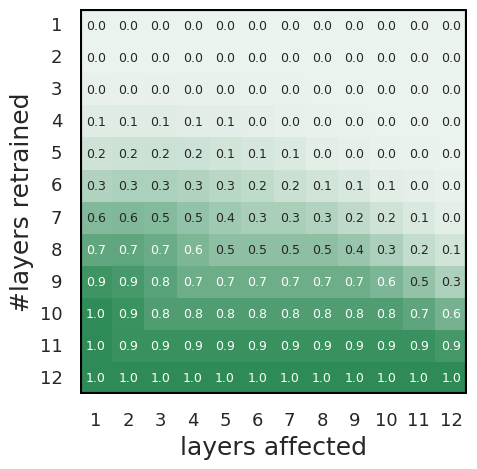

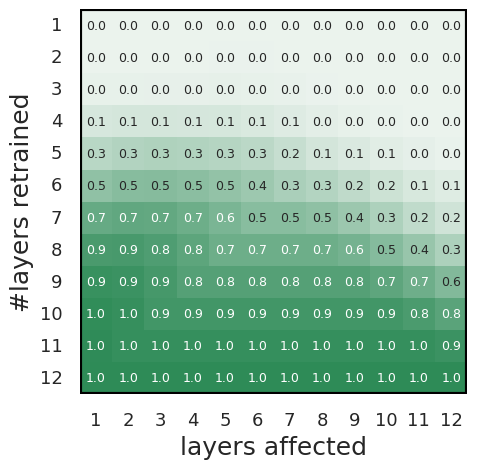

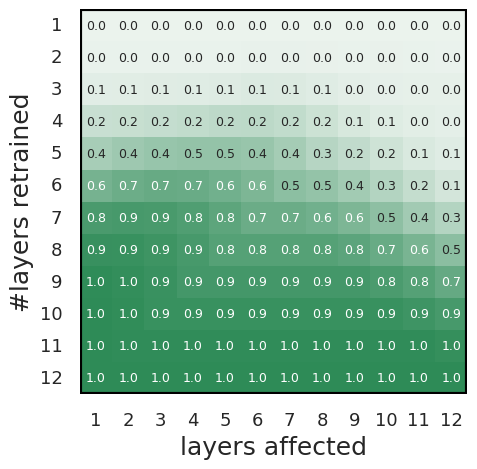

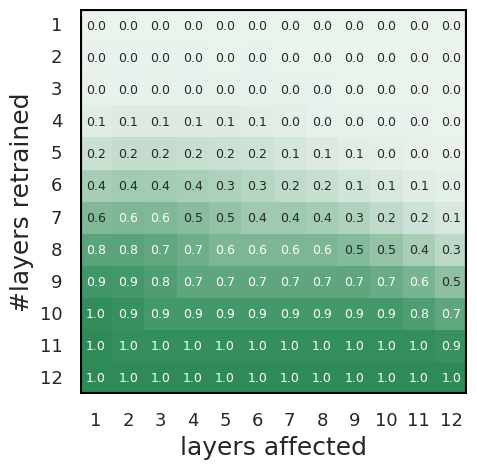

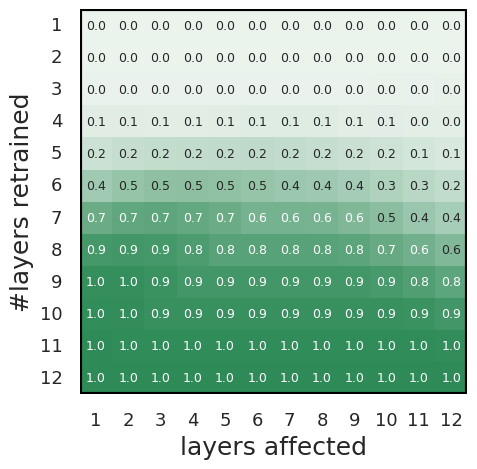

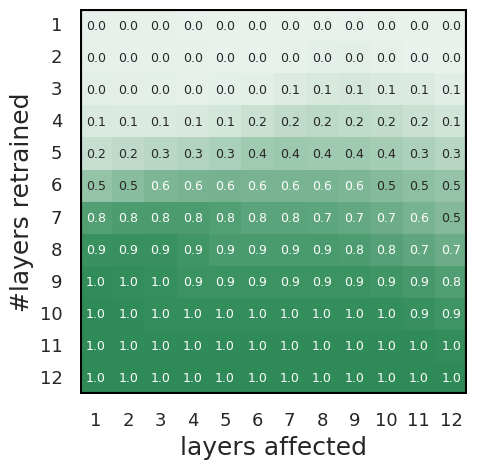

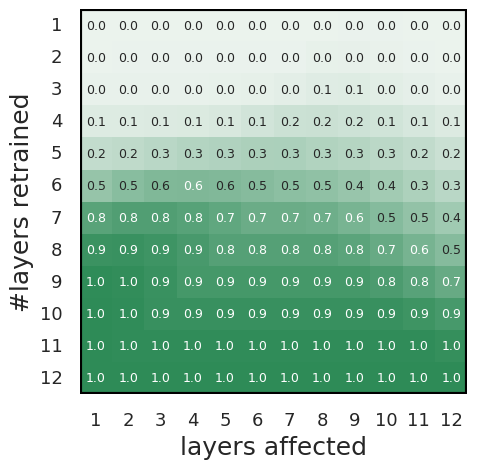

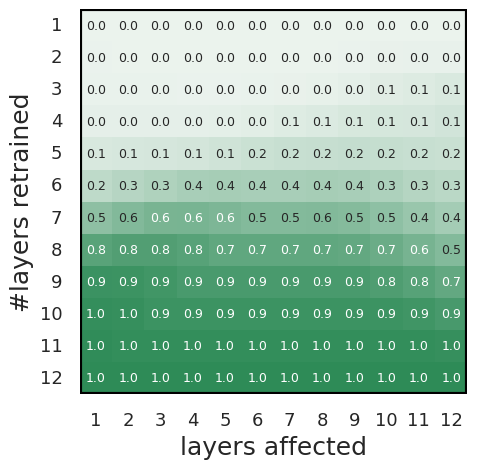

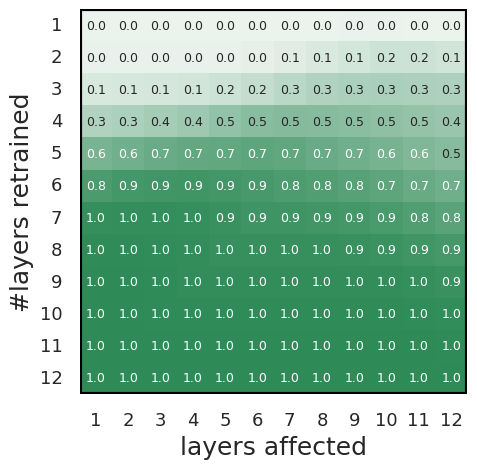

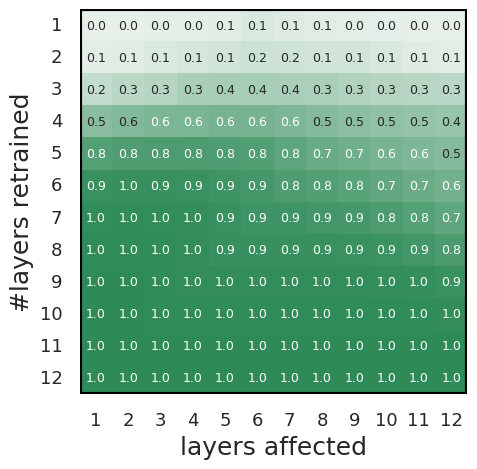

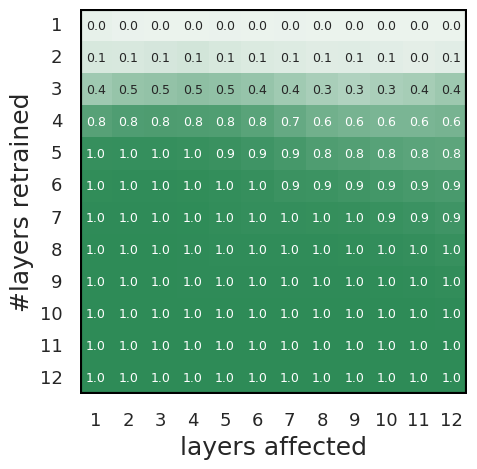

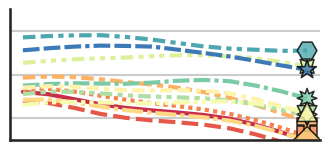

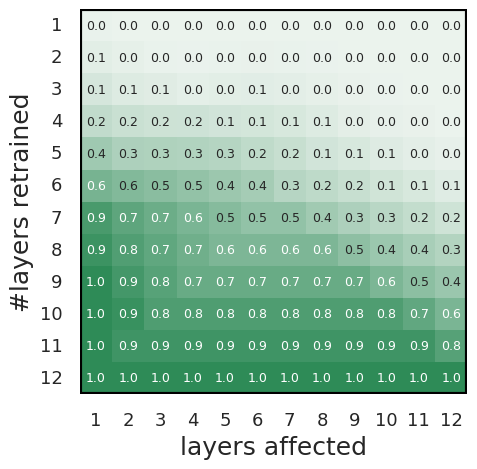

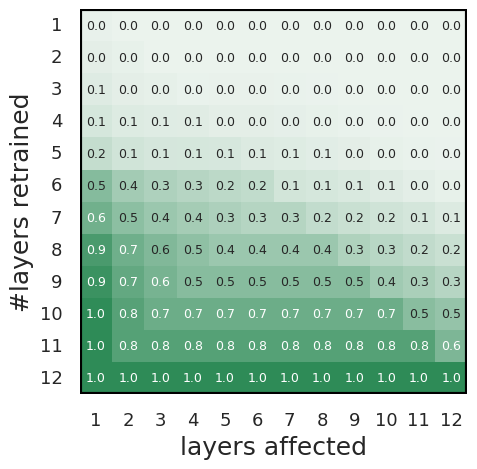

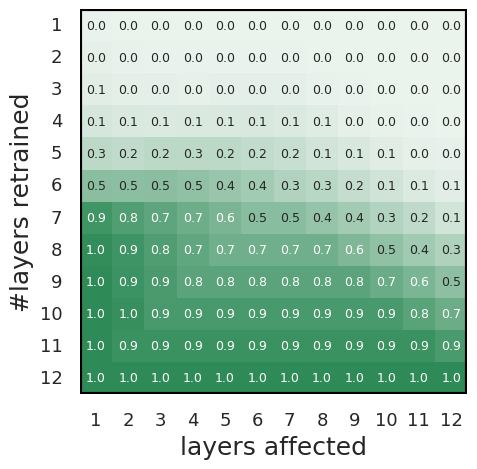

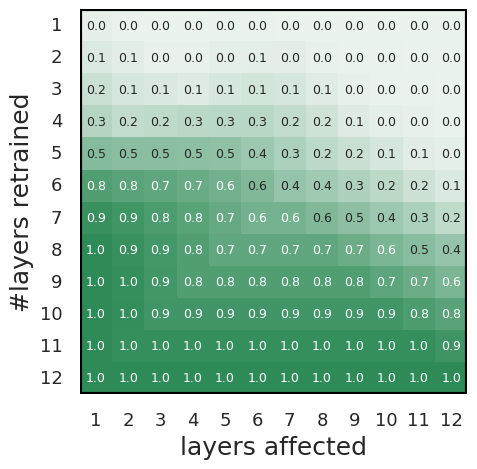

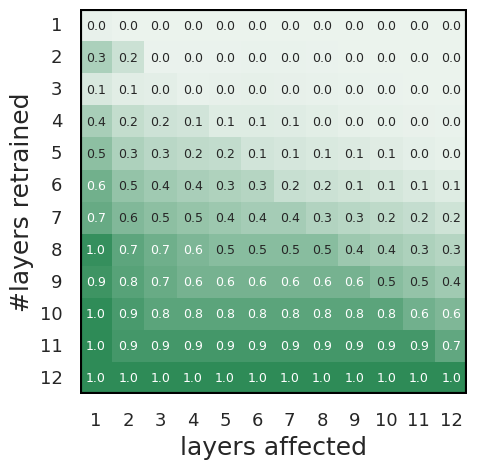

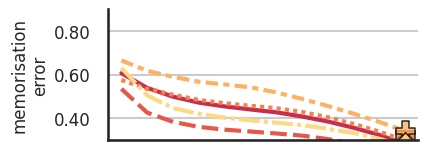

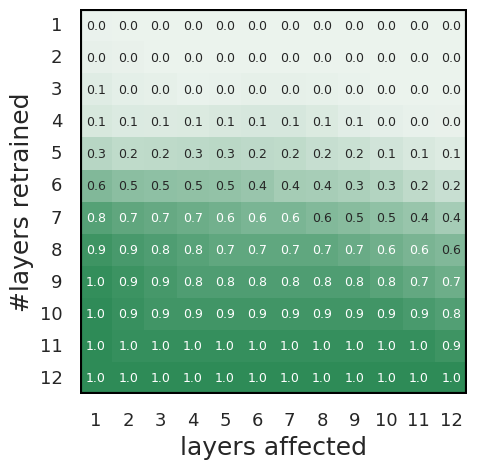

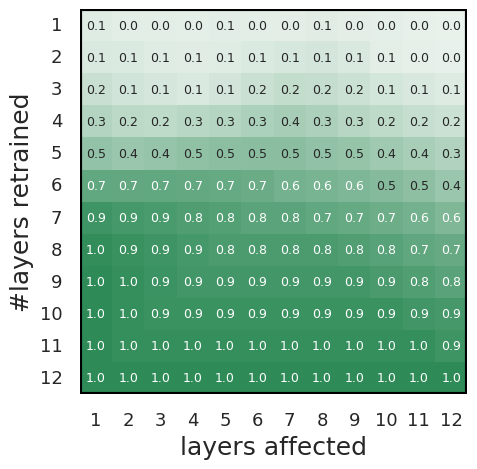

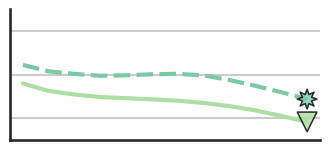

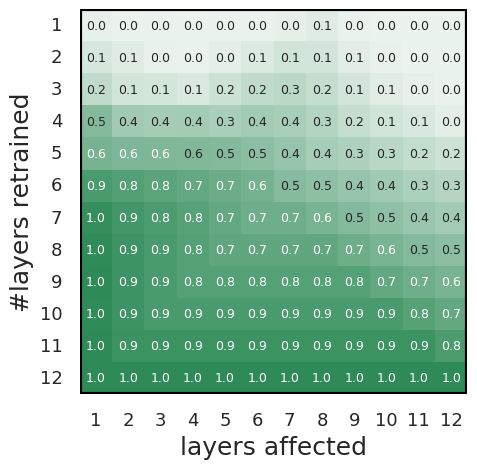

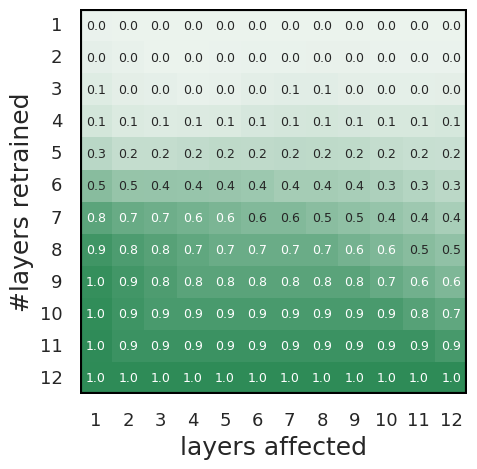

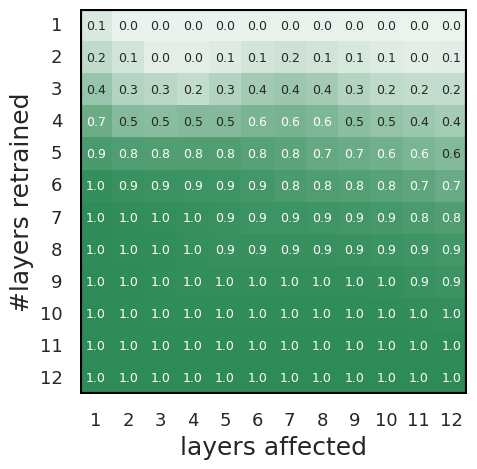

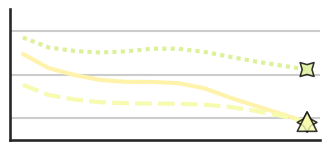

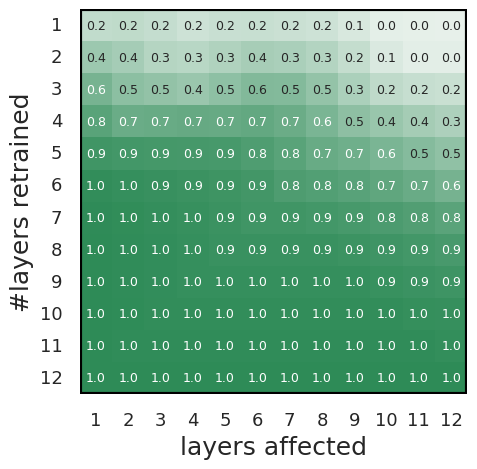

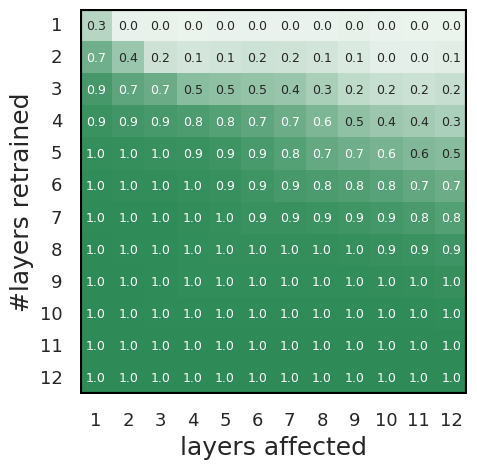

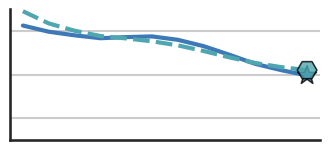

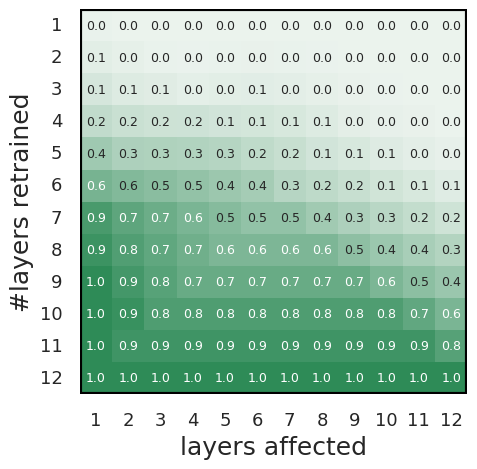

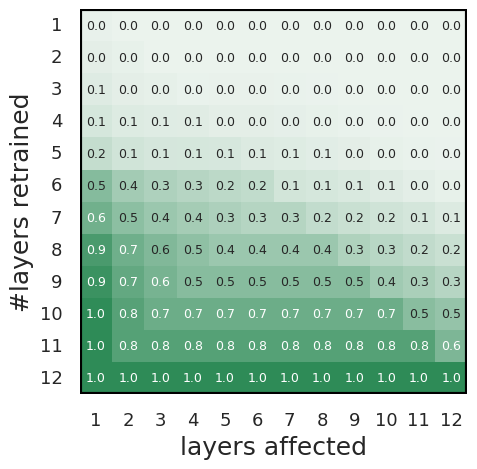

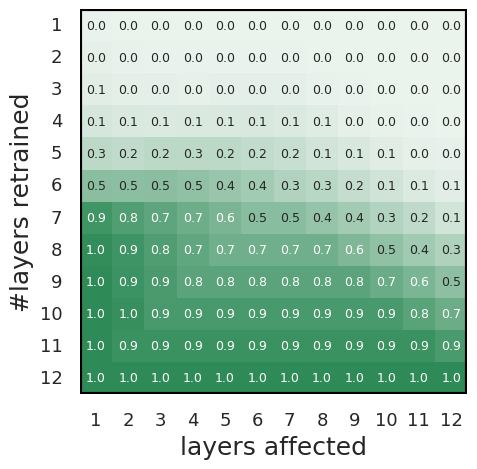

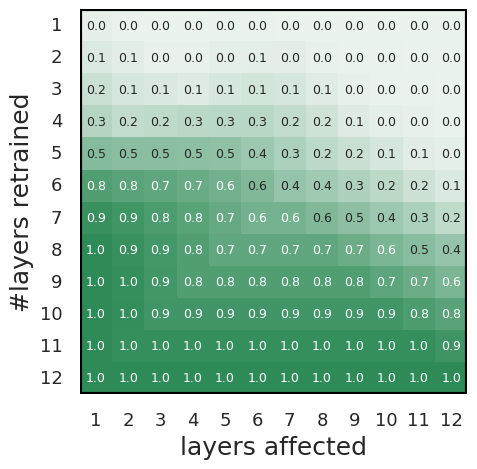

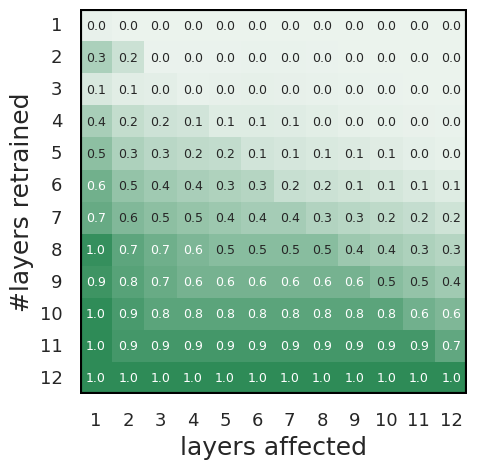

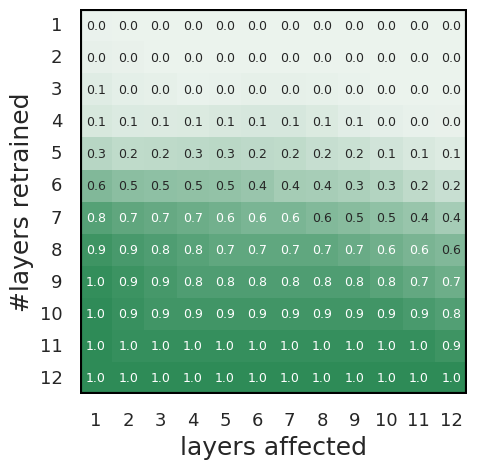

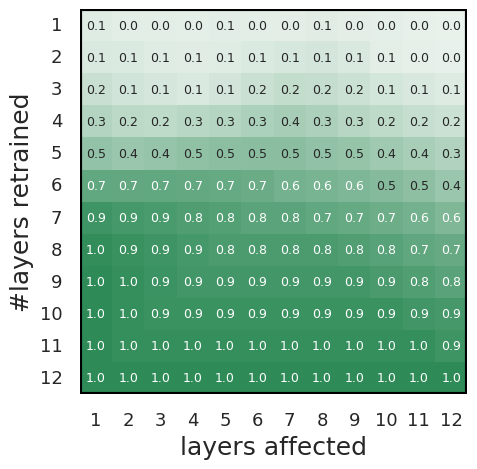

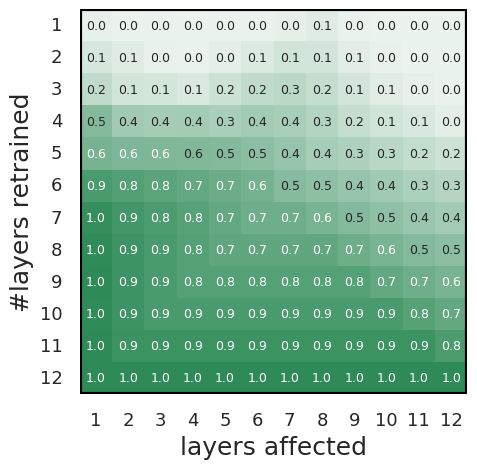

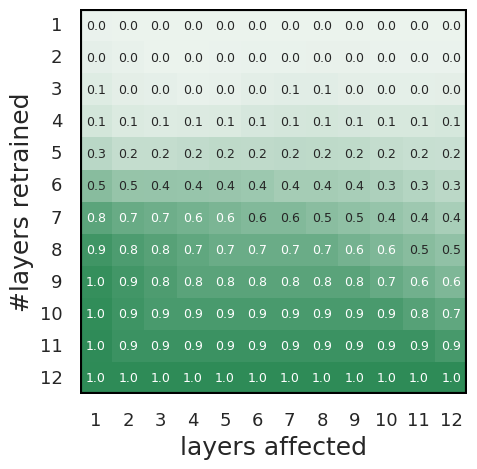

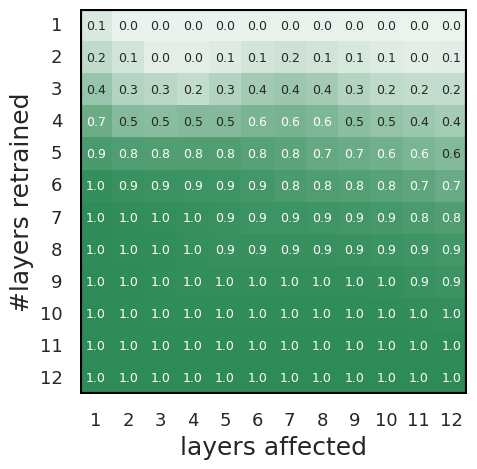

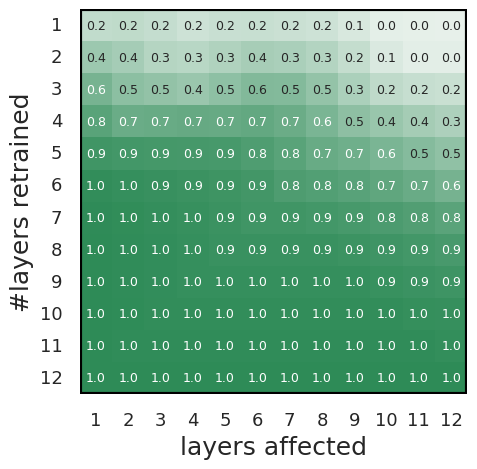

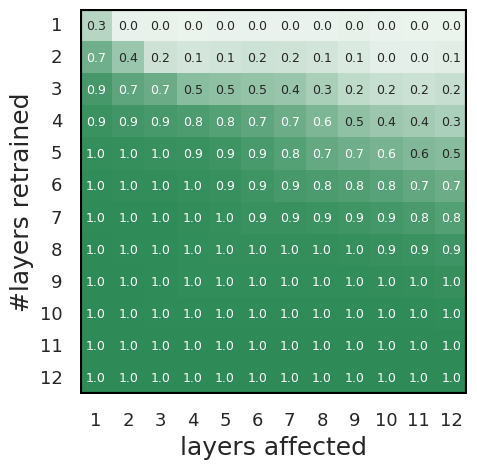

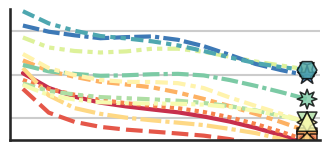

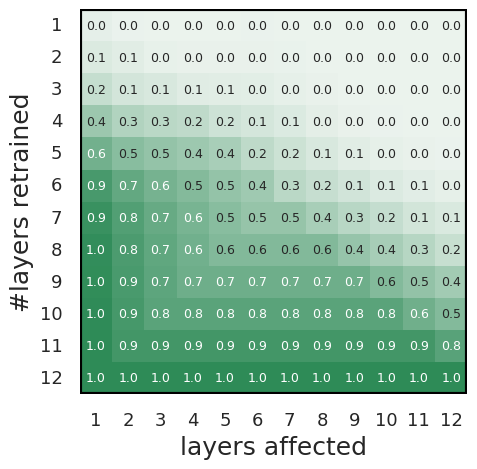

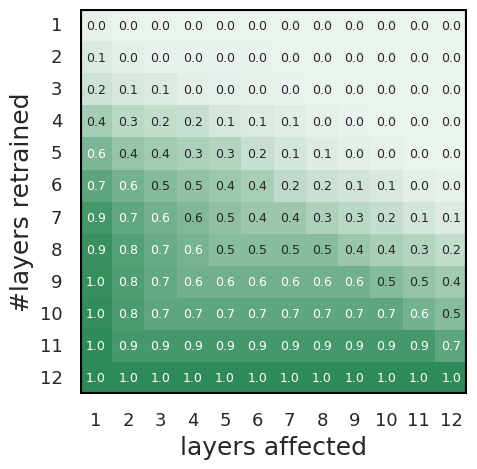

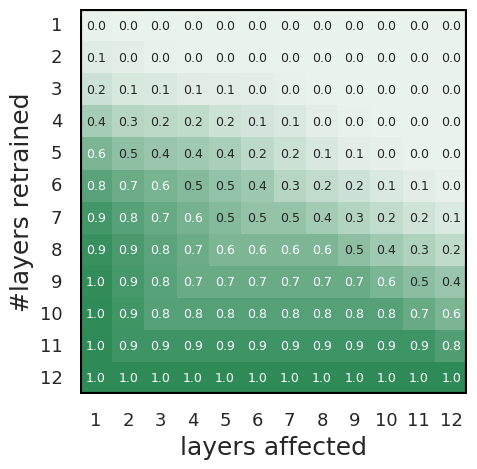

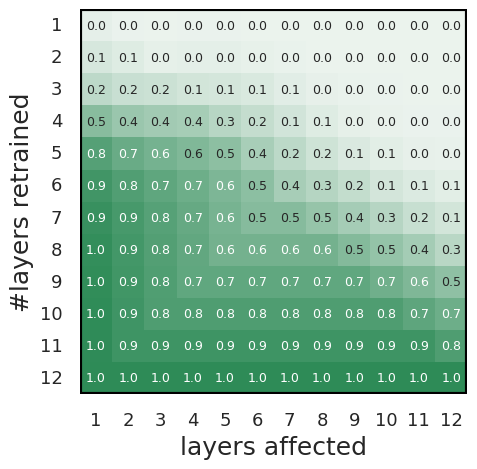

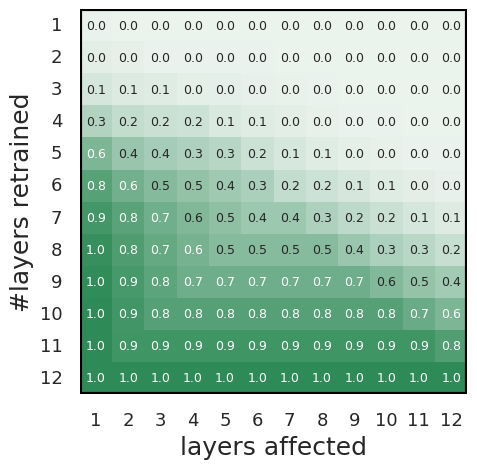

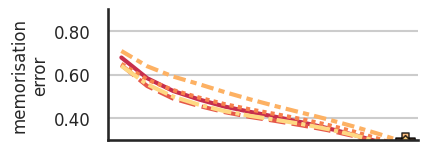

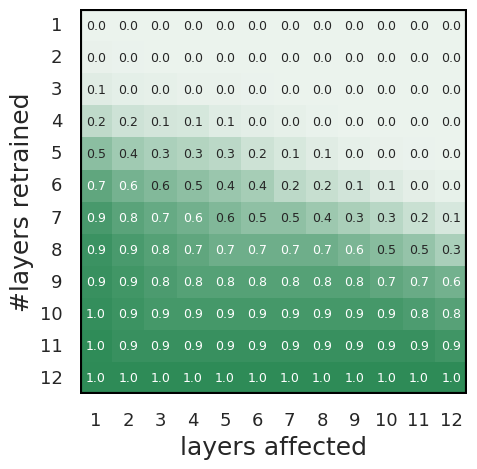

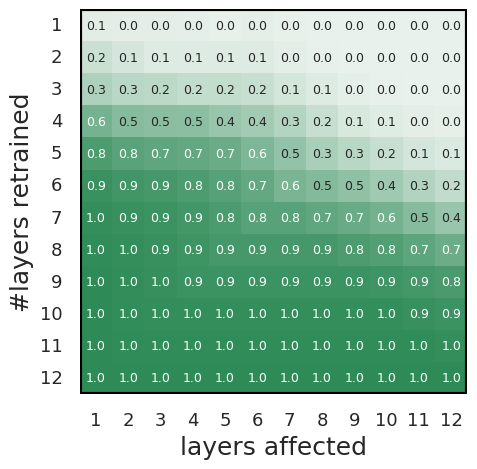

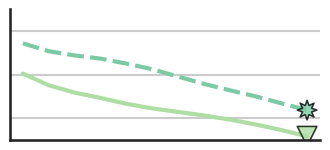

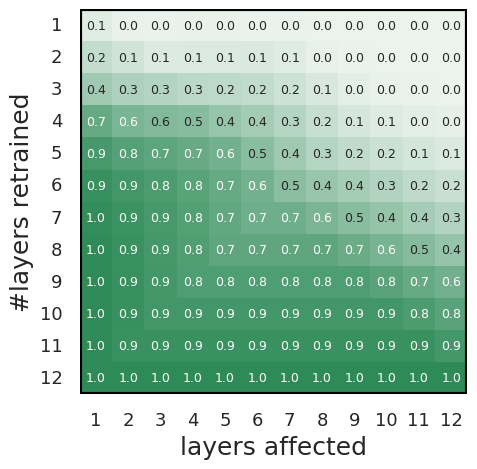

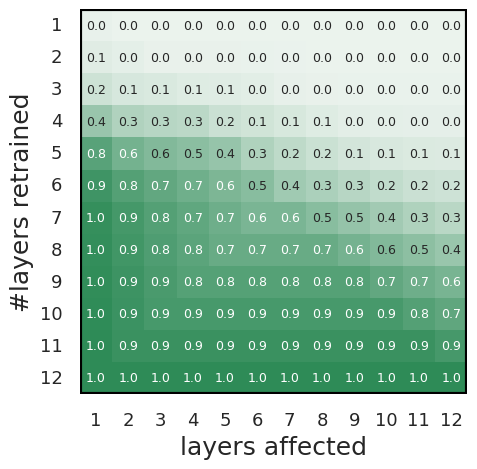

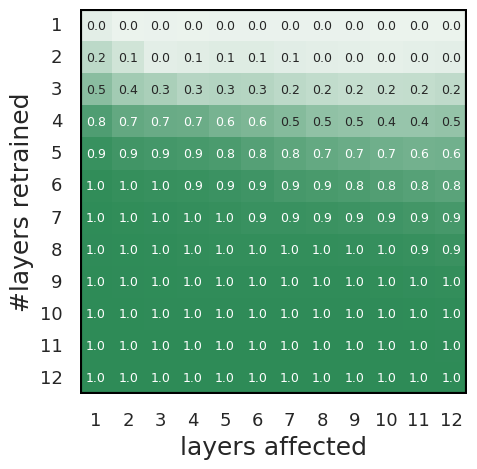

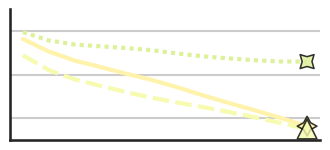

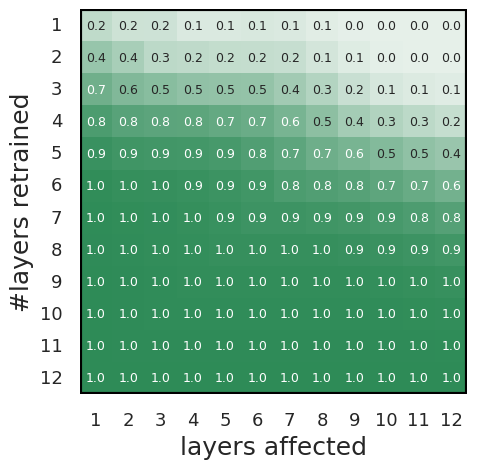

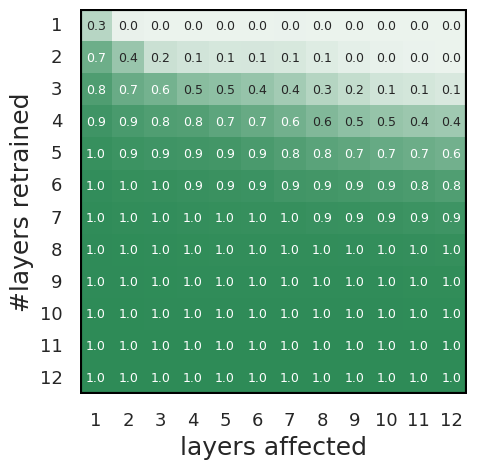

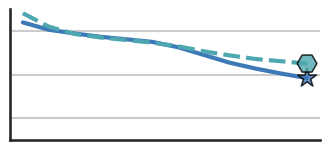

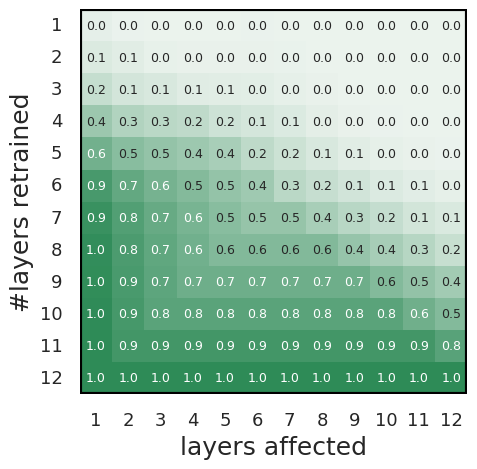

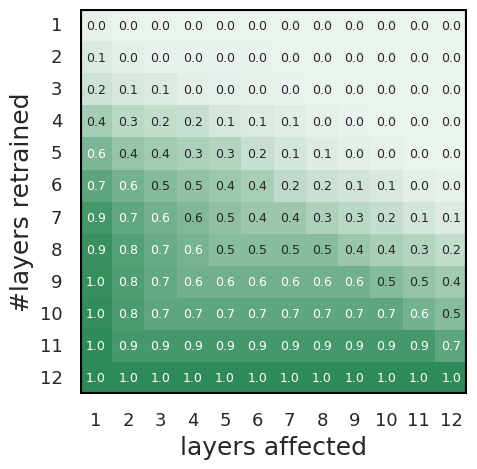

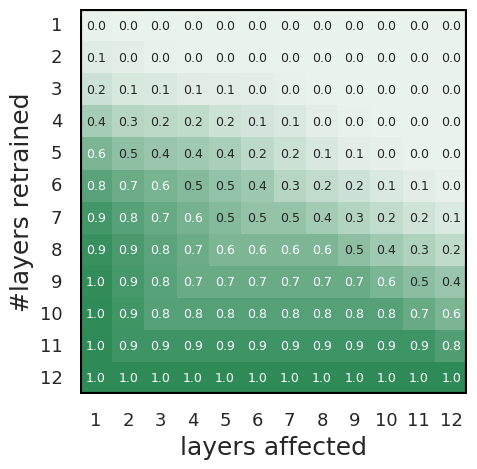

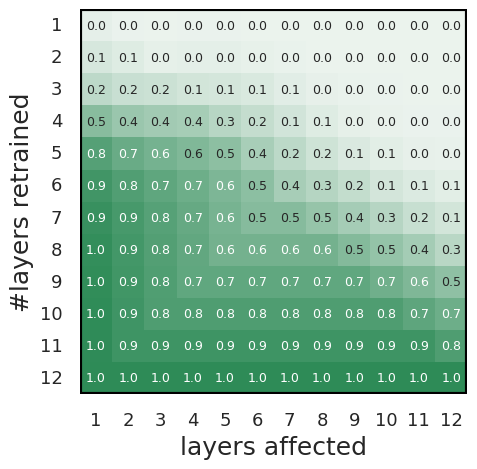

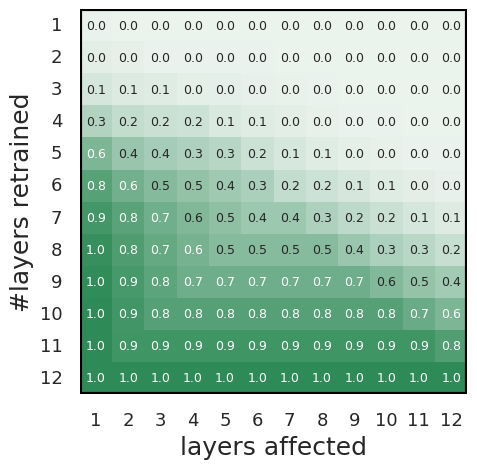

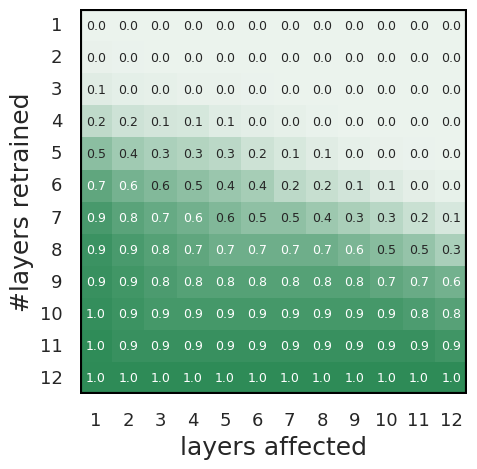

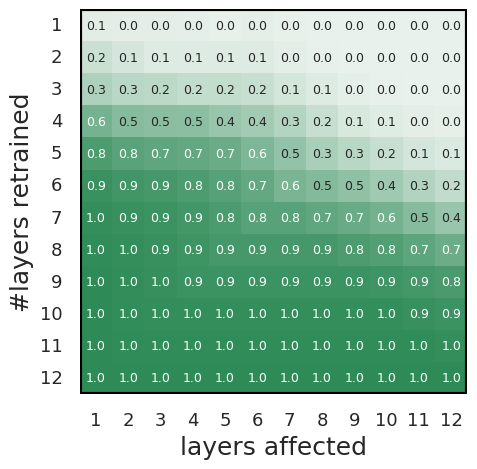

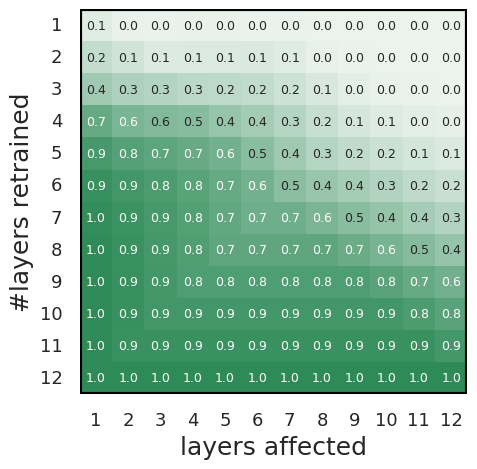

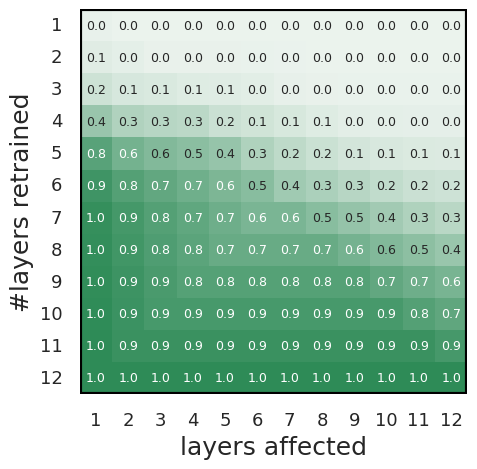

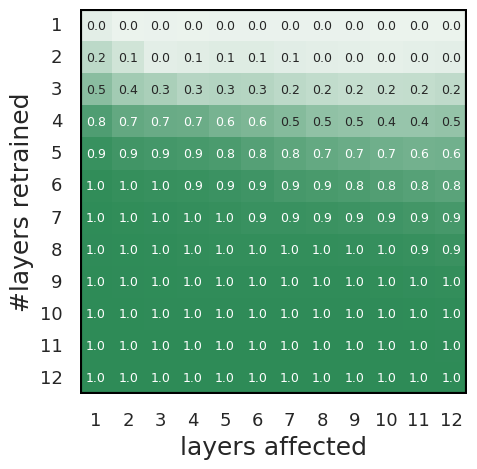

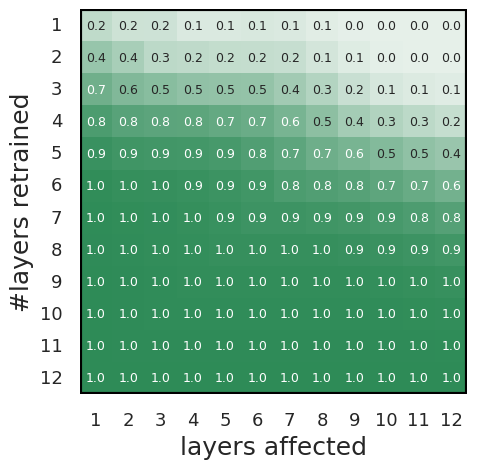

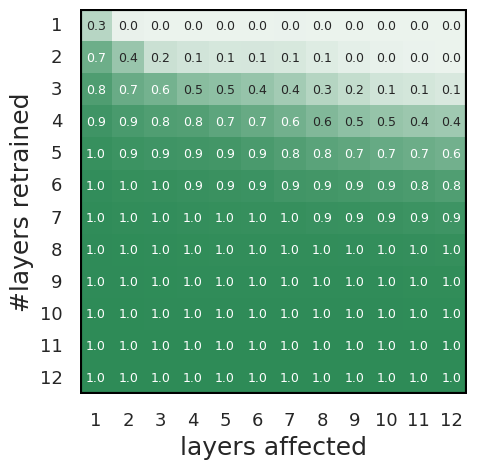

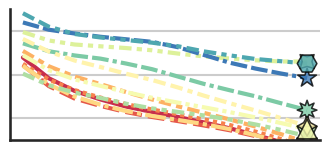

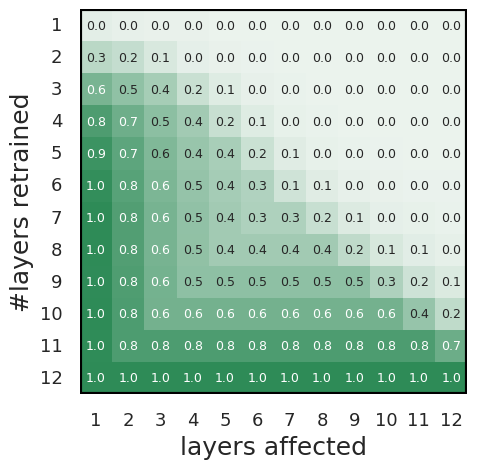

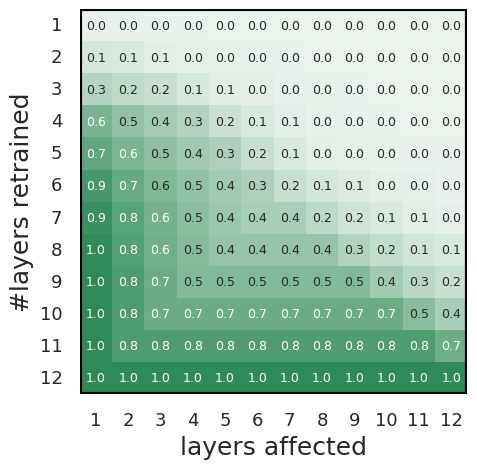

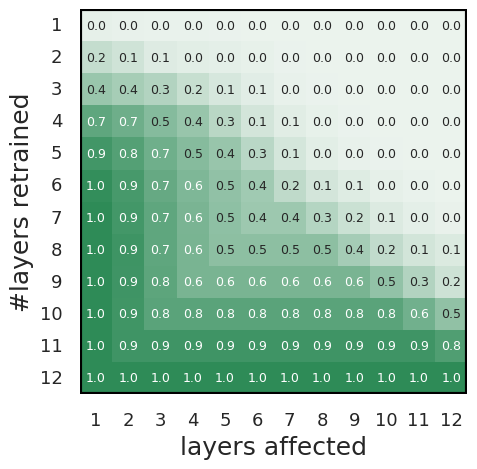

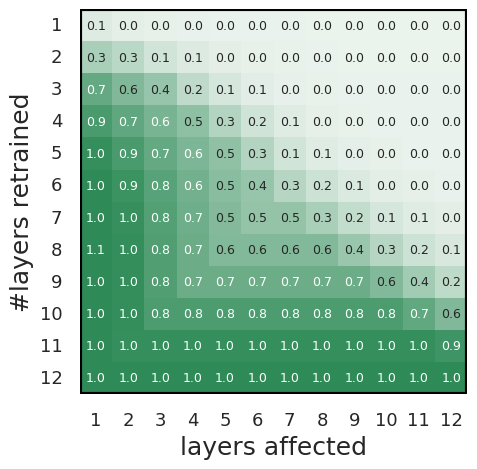

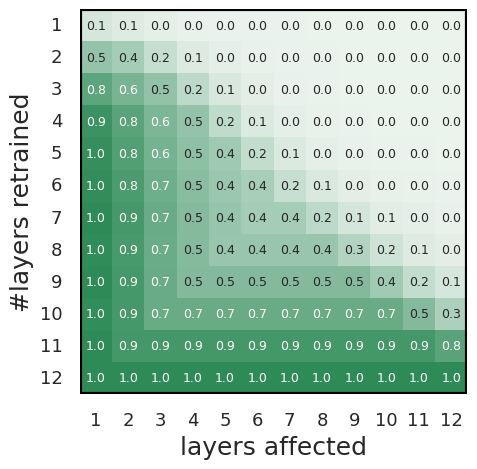

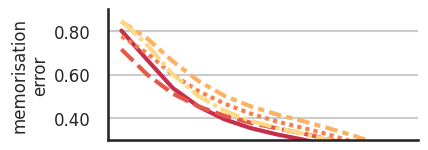

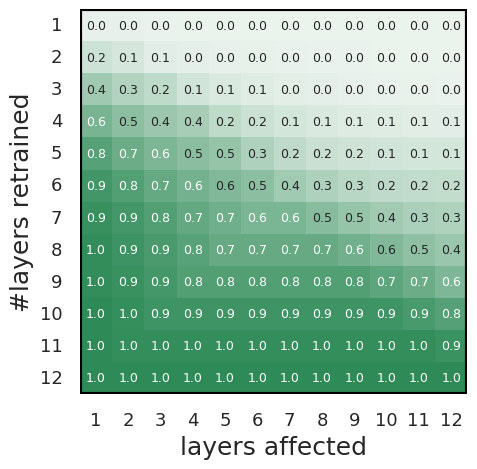

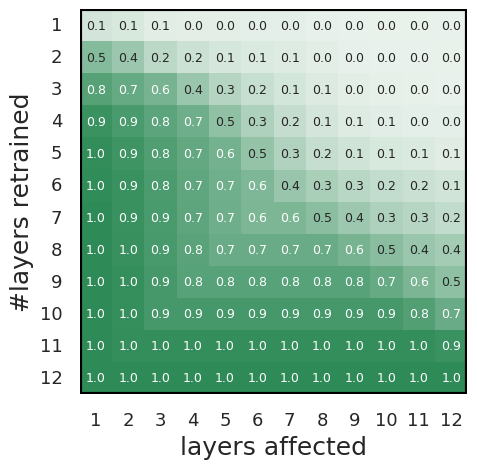

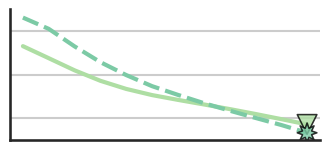

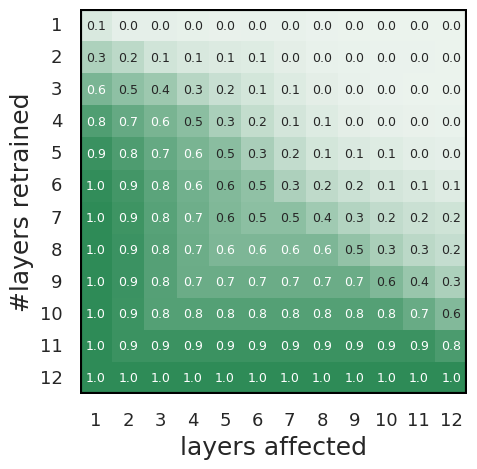

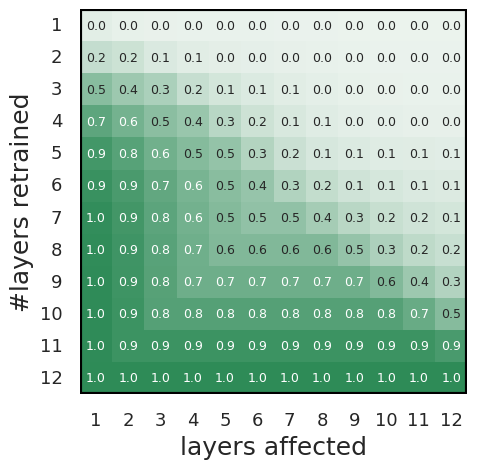

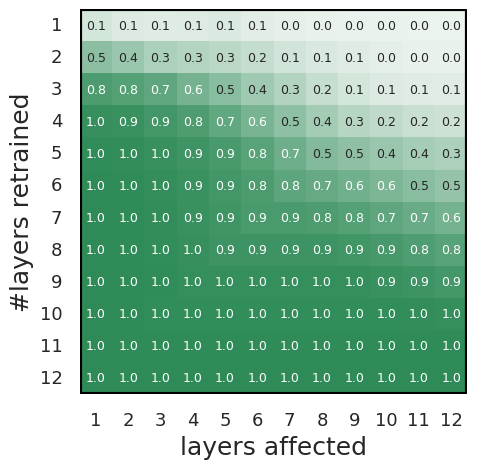

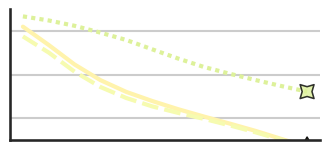

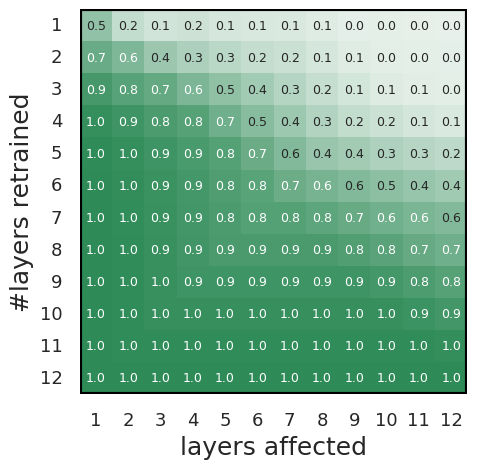

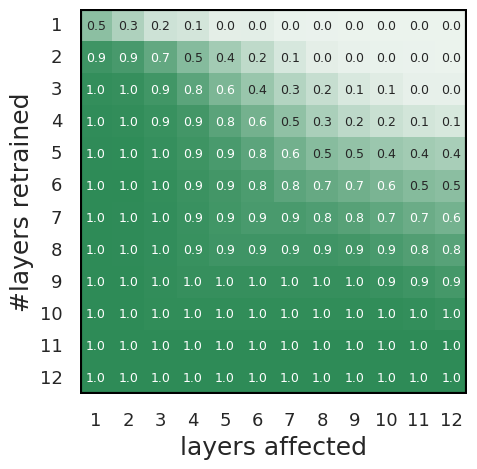

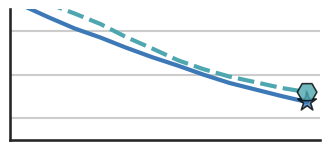

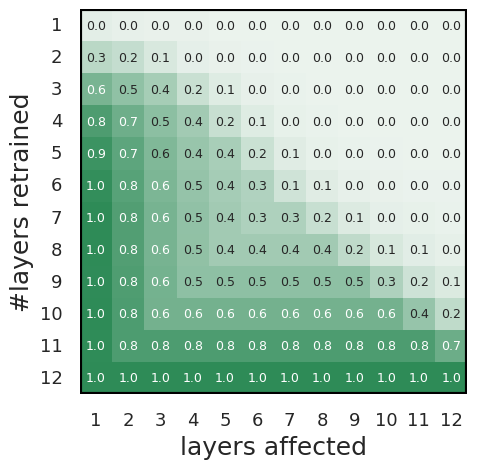

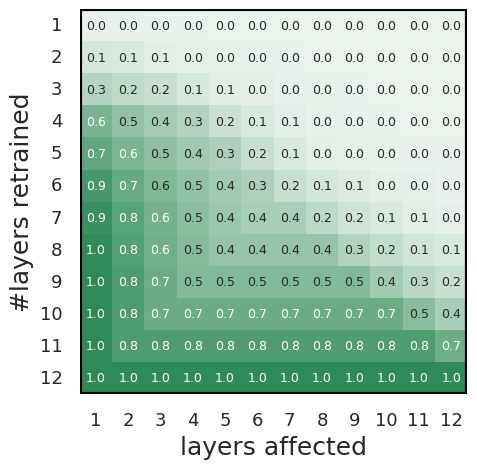

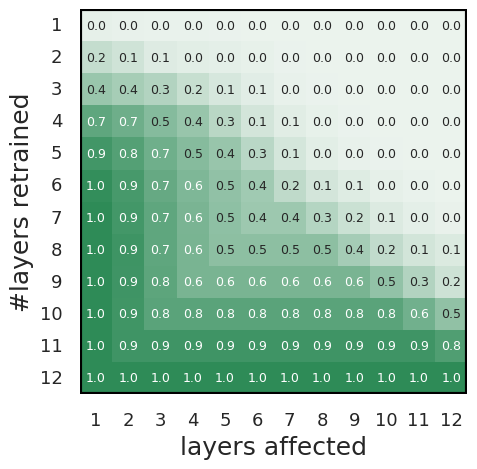

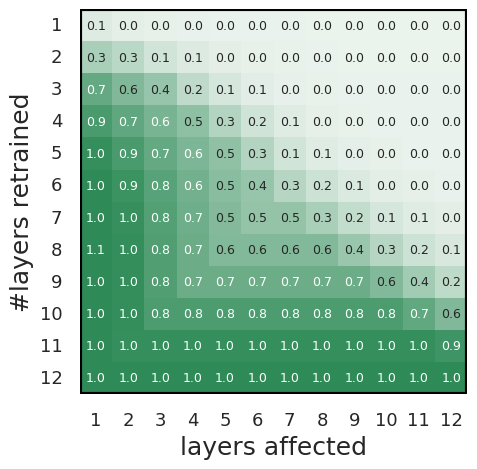

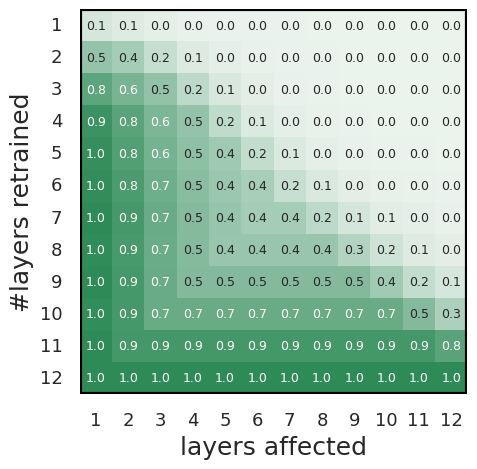

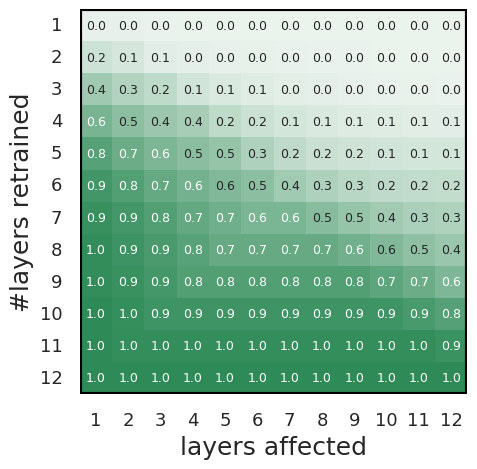

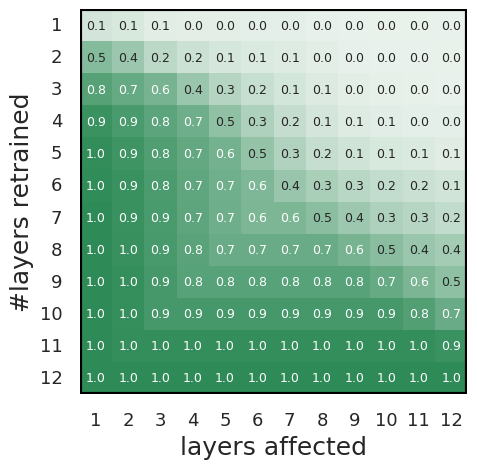

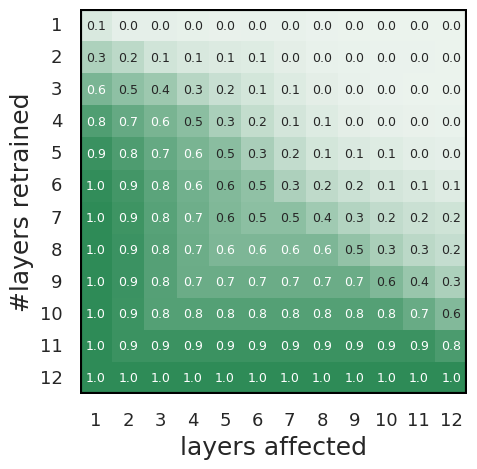

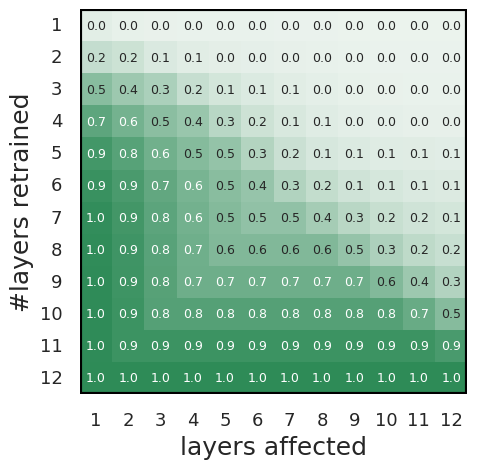

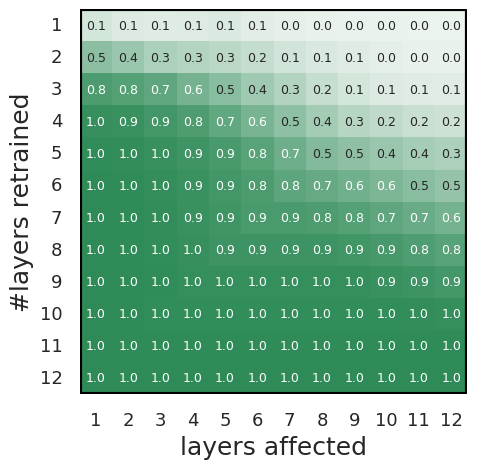

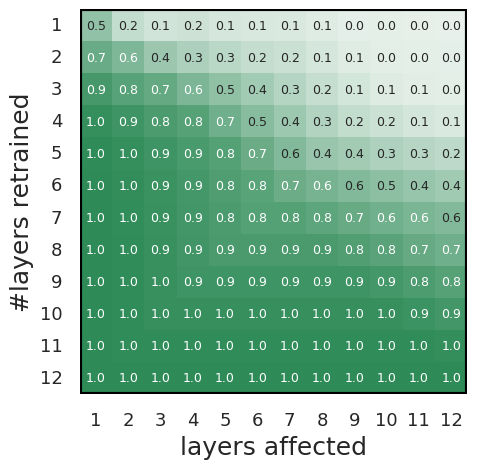

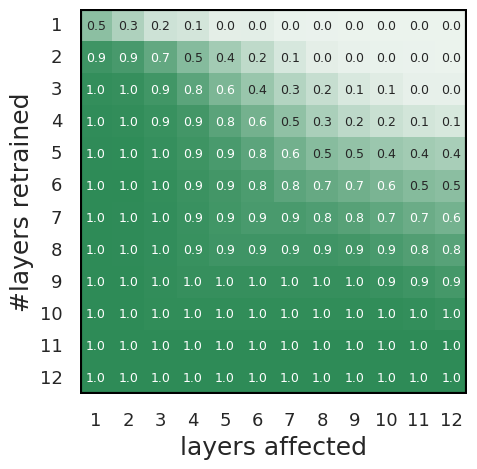

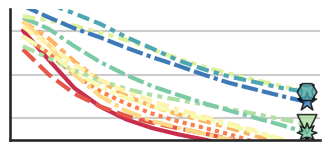

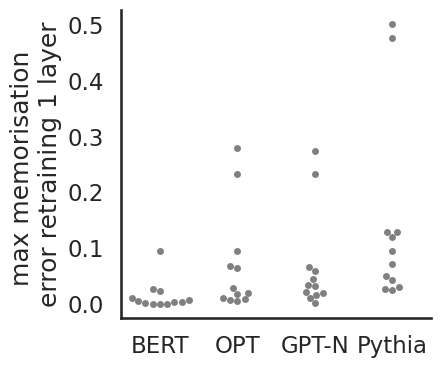

In [3]:
def visualise_retraining(data_setups, seeds=[1, 2, 3]):
    results = defaultdict(lambda: dict())
    results_top_row = defaultdict(lambda: dict())
    mcog = defaultdict(lambda: dict())
    
    for modeln, model in utils.model_setups:
        for setup, ds_names in utils.data_setups:
            allx, ally, allh = [], [], []
            for dataset in ds_names:
                heatmaps = []
                for seed in seeds:
                    fn = f"../results/layer_retraining/{dataset}/{model}_seed={seed}_freeze=embeddings_epoch=50.pt.pickle"
                    dict_ = pickle.load(open(fn, 'rb'))
                    heatmap, _ = \
                        utils.get_heatmap_and_averages(fn, retraining=True)
                    heatmaps.append(heatmap)

                heatmap_over_seeds = np.array(heatmaps).mean(axis=0)

                # Store individual heatmaps for model - dataset combinations
                utils.save_heatmap(
                    heatmap_over_seeds, f"layer_retraining/{model}_{dataset}.pdf",
                    label="retrained")
                flattened_heatmap = heatmap_over_seeds.mean(axis=0).tolist()
                results[model][dataset.replace("v2", '')] = flattened_heatmap
                results_top_row[model][dataset] = heatmap_over_seeds[0].tolist()
       
                mcog[model][dataset.replace("v2", '')] = \
                    np.sum([x_*y_ for x_, y_ in zip(range(0, 12), flattened_heatmap)])/np.sum(flattened_heatmap)
                allx.extend(list(range(12)))
                ally.extend(flattened_heatmap)
                allh.extend([dataset]*12)

            # Visualise the flattened heatmaps per group of datasets (setup)
            utils.visualise_flattened_heatmap(allx, ally, allh, setup, modeln, retraining=True)

    utils.visualise_single_row(results_top_row, retraining=True)
    return dict(results), dict(mcog)        

results, mcog = visualise_retraining(utils.data_setups)
pickle.dump((dict(results), dict(mcog)), open("pickled_results/retraining_main.pickle", 'wb'))

### Section 4.1, Figure 6

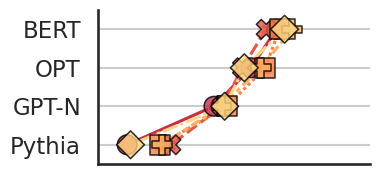

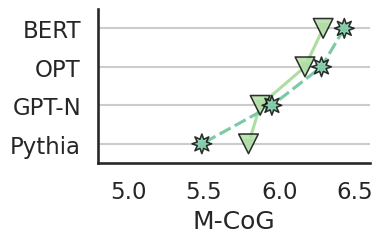

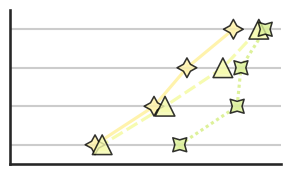

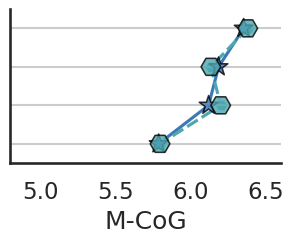

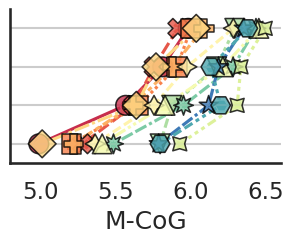

In [4]:
for group, ds_names in utils.data_setups:
    plt.figure(figsize=(3.5, 2))
    sns.set_style("white")
    plt.grid(axis='y', zorder=-1)
    x = [mcog[m][d] + 1 for m in mcog for d in ds_names]
    y = [utils.shorten(model) for model in mcog for m in [model]*len(ds_names)]
    hue = [d for m in mcog for d in ds_names]
    ax = sns.scatterplot(
        x=x, y=y, hue=hue, style=hue,
        palette=utils.palette, edgecolor='black', s=200,
        markers=utils.marker_dict, alpha=0.8)
    sns.lineplot(
        x=x, y=y, hue=hue, style=hue,
        palette=utils.palette, orient='y', zorder=-1,
        legend=False, markers=utils.marker_dict)
    ax.set_xticks([5, 5.5, 6, 6.5])
    plt.legend([],[],frameon=False)
    if group not in ["nlu", "hate"]:
        ax.set_yticklabels([])
    if group in ["nlu", "sentiment"]:
        ax.set_xticks([])
    if group not in ["nlu", "sentiment"]:
        plt.xlabel("M-CoG")
    plt.ylim(3.5, -0.5)
    plt.xlim(4.8, 6.6)
    sns.despine()
    plt.savefig(f"layer_retraining/retraining_cog_{group}.pdf", bbox_inches="tight")
    plt.show()


### Section 4.1: Correlate M-CoG coefficients with one another

In [5]:
corrs = []
for m in mcog:
    for m2 in mcog:
        if m == m2:
            continue
        r, p = scipy.stats.spearmanr(
            list(mcog[m].values()), list(mcog[m2].values()))
        if p > 0.05:
            print(m, m2, r, p)
        corrs.append(r)
print(np.mean(corrs))

0.8508158508158509
